# Pytorch Workflow

### An end-to-end pytorch worflow

In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn ## nn contains all of pytorchs's building blocks for neural networks
import matplotlib.pyplot as plt

# check pytorch version
torch.__version__

'1.11.0+cpu'

## 1. Data Preparing and Loading

### Let's create some *know* data using linear regression formula. We'll use a linear regression formula to make a straight line with *know* **parameters**

In [3]:
### Create *know* parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step =0.02
X = torch.arange(start,end, step).unsqueeze(dim=1)
y = weight * X + bias

In [4]:
X[:10], y[:10], X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 torch.Size([50, 1]),
 torch.Size([50, 1]))

### Splitting data into training and test set

In [5]:
len(X), len(y)

(50, 50)

In [6]:
# create a train-test split
train_split = int(0.8 * len(X))
train_split

40

In [7]:
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [8]:
len(X_train), len(X_test)

(40, 10)

## Plot predictions

In [9]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_lables=y_test,
                     predictions=None):
    """
    Plots training data, test data and compare predictions
    """
    plt.figure(figsize=(10,7))
    
    # plot training data
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
    
    # plot testing data
    plt.scatter(test_data, test_lables, c="g", s=4, label="Testing Data")
    
    # are there predictions?
    if predictions is not None:
        # plot the predictions if they exists
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # show legends
    plt.legend(prop={"size": 14})

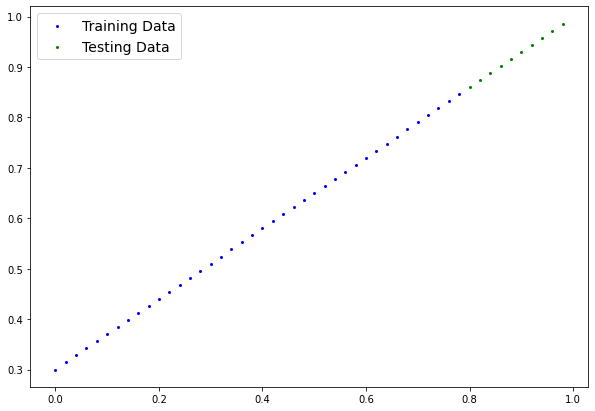

In [10]:
plot_predictions()

# Build Model

Our first pytorch model - Linear Regression

### Linear regression Model class

In [11]:
class LinearRegressionModel(nn.Module): # almost everything in Pytorch inherits from nn.Module
    
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    # forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # "x"is a input data
        return self.weight * x + self.bias # this is the linear regression formula

### Pytorch model building essentials

* torch.nn - contains all the building blocks for computational graphs ( a Neural Network can be consideted as computational graphs)
* torch.nn.Parameter - what parameters should our model try and learn - Often a pytorch layer from torch.nn will try and set this for us
* torch.nn.Module - The base class for all neural network modules , if you subclass this, you should override the *forward* method
* torch.optim - This is where where the optimizers in Pytorch live, will help with gradient descent
* def forward() - All nn.Module subclassses require you to overwrite forward(), this methods defines what happens in forward computation

### Checking the contents of our pytorch model

Now that we have created our model, let's check what is inside this model

Checkout model paarmerets using .parameters()

In [12]:
# create a random seed
torch.manual_seed(42)

# create an instance of our model
model_0 = LinearRegressionModel()

# checkout the paarmeters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
# List of named paarmeters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using the torch.inference_mode()

To check our model's pedictive power, let's see how well its predicts 'y_test' based on 'X_test'

When we pass our data through our model, its is going to run it through the 'forward()' method

In [14]:
# make predictions with model

with torch.inference_mode():
    y_preds = model_0(X_test)
    
# you can do something similar using torch.no_gard() but inference_mode is prefered
# with torch.no_grad():
#     y_pred = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

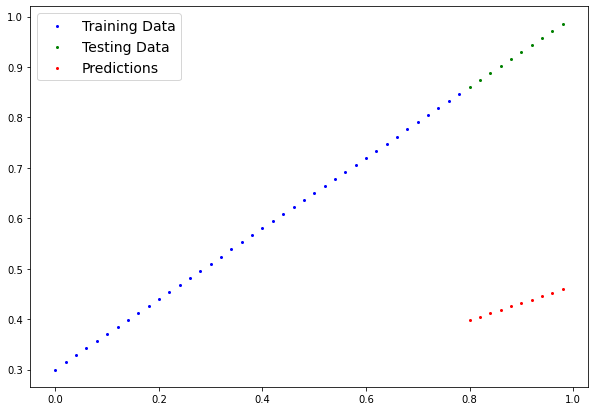

In [15]:
plot_predictions(predictions=y_preds)

## Training Model

## Things we need to train model:

* loss function
* optimizer
* training loop
* testing loop

### Loss Function: A way to measure how wrong your model predictions are. Lower are better

### Optimizer: Takes into account the loss of a model and adjusts the model's parameters to improve the loss function

In [16]:
## Setup a loss function
## Mean Absolute Error ( MAE or L1 Loss)

loss_fn = nn.L1Loss()

## Set up a optimizer ( Stochastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.01)

## Building a Training and Testing Loop

Things we need a training loop

1. Loop through the data
2. Forward pass ( this involves data moving through model's forward()) - forward propogation - to make predictions
3. Calculate the loss ( compare the forward pass predictions to ground truth)
4. Optimizer zero grad
5. Loss backward - moves backward through the network to calculate the gardients of each of the parameters of our model with respect to loss function - back propagation
6. Optimizer step - use the optimizer to adjust the model parameters to try and improve the loss

In [17]:
torch.manual_seed(42)
# An epoch one loop through the complete data, one of the hyperparameter
epochs = 100

# Loop through the data
for epoch in range(epochs):
    # set the model to training model
    model_0.train() # train mode in pytorch sets all the parameters that requires gardient to require_gradients=True
    
    # 1. Forward method
    y_pred = model_0(X_train)
    
    #2. Calculate Loss
    loss = loss_fn(y_pred, y_train)
    print(loss)
    #3. Optimizer zero grad
    optimizer.zero_grad()
    
    #4.Perform back propagation
    loss.backward()
    
    #5. Perform gardient descent
    optimizer.step() # be default how the optimizer change will accumulate through the loop.. so we have to zero them in step 3
    
    
    # Testing
    model_0.eval() # turns-off dfferent settings ( including dropout, batch-norm) not needed for testing
    with torch.inference_mode(): # turns off gradient tracking and couple of other things behind the scenes
        # 1. forward pass
        test_pred = model_0(X_test)
        
        # 2. calculate test loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
        print(f"Epoch:{epoch} | Loss:{loss} | Test Loss:{test_loss}")
        
        # print model state
        print(model_0.state_dict())

tensor(0.3129, grad_fn=<L1LossBackward0>)
Epoch:0 | Loss:0.31288138031959534 | Test Loss:0.48106518387794495
OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
tensor(0.3014, grad_fn=<L1LossBackward0>)
tensor(0.2898, grad_fn=<L1LossBackward0>)
tensor(0.2783, grad_fn=<L1LossBackward0>)
tensor(0.2668, grad_fn=<L1LossBackward0>)
tensor(0.2553, grad_fn=<L1LossBackward0>)
tensor(0.2438, grad_fn=<L1LossBackward0>)
tensor(0.2322, grad_fn=<L1LossBackward0>)
tensor(0.2207, grad_fn=<L1LossBackward0>)
tensor(0.2092, grad_fn=<L1LossBackward0>)
tensor(0.1977, grad_fn=<L1LossBackward0>)
Epoch:10 | Loss:0.1976713240146637 | Test Loss:0.3463551998138428
OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
tensor(0.1862, grad_fn=<L1LossBackward0>)
tensor(0.1746, grad_fn=<L1LossBackward0>)
tensor(0.1631, grad_fn=<L1LossBackward0>)
tensor(0.1516, grad_fn=<L1LossBackward0>)
tensor(0.1401, grad_fn=<L1LossBackward0>)
tensor(0.1285, grad_fn=<L1LossBackward0>)
tensor(0.

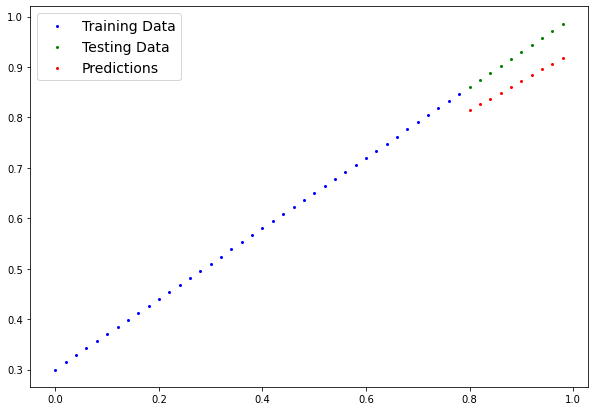

In [18]:
# make predictions
with torch.inference_mode():
    y_pred = model_0(X_test)
    
plot_predictions(predictions=y_pred)